In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [41]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Thomas\AppData\Local\Temp\ipykernel_21160\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [42]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [43]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [45]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


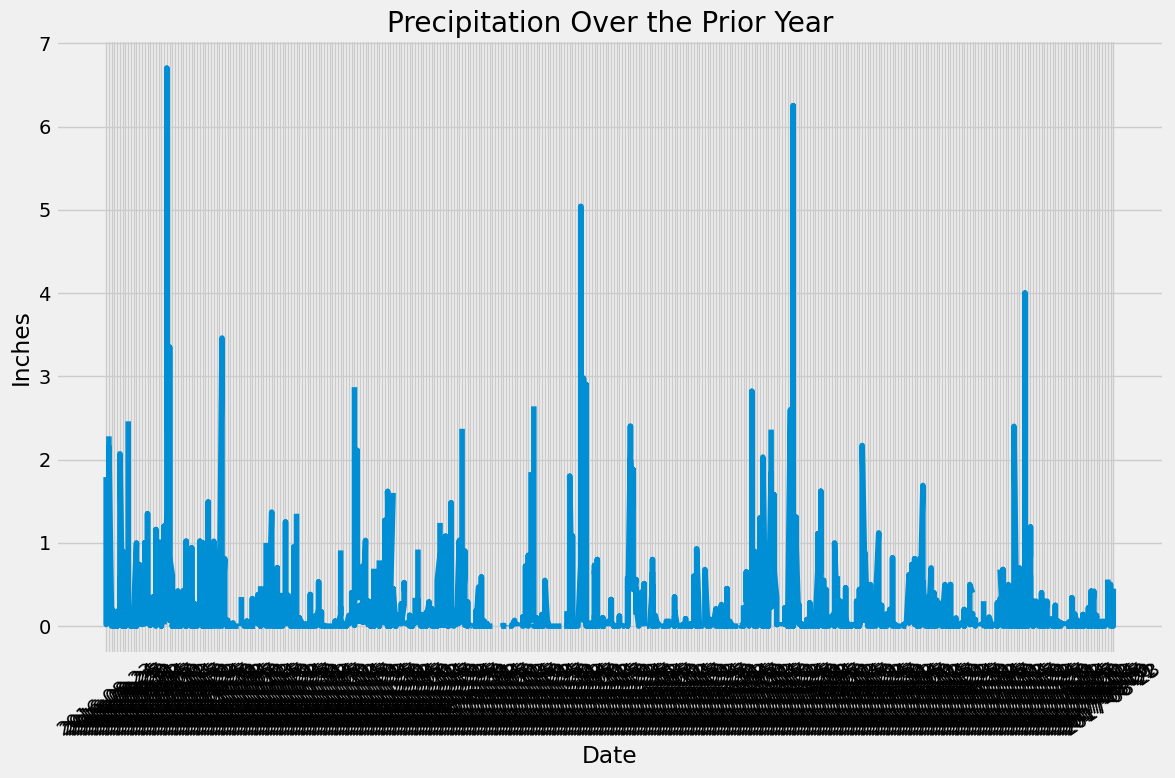

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
dt_year_prior = (dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
year_prior_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= dt_year_prior).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(year_prior_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 8))
plt.plot(precipitation_df['Date'], precipitation_df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Over the Prior Year')
plt.xticks(rotation=35)
plt.tight_layout()
plt.show()

In [57]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [58]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(station).count()

9

In [64]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(
    measurement.station,
    func.count(measurement.station).label('count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [69]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

most_active_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()

most_active_station_id, most_active_stats

('USC00519281', [(54.0, 85.0, 71.66378066378067)])

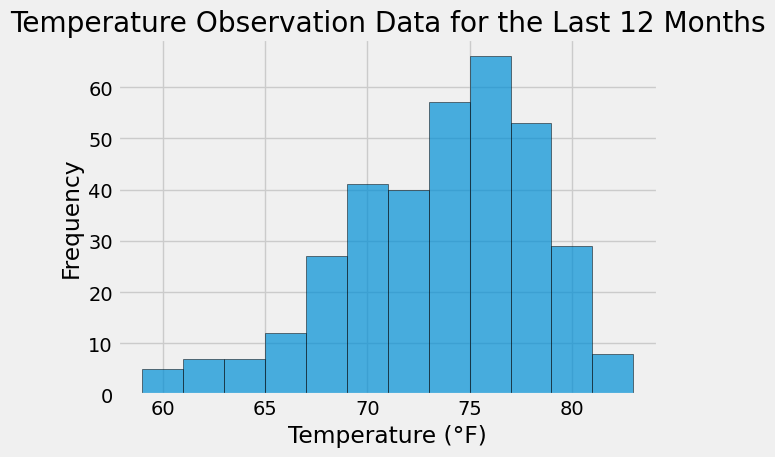

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_prior_year = (session
    .query(measurement.station, measurement.tobs)
    .filter(measurement.date >= dt_year_prior)
    .filter(measurement.station == most_active_station_id)
.all())

most_active = pd.DataFrame(most_active_prior_year, columns=['station', 'temperature'])

plt.hist(most_active['temperature'], bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for the Last 12 Months')
plt.tight_layout()
plt.show()

# Close Session

In [78]:
# Close Session
session.close()